In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## for feature slection

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

In [2]:
training_data = pd.read_csv('../dataset/final_dataset/gkm/train.csv')
training_data.head()

,latitude,longitude,depth,magnitude,distance,gravity,force,year,month,day,hour,minutes,mb,mwb,mwc,mwr,mww,rare_mt
0,-6.7306,155.0899,3.555348,5.1,12.808255,2.280247,46.837415,2014,12,23,21,19,1,0,0,0,0,0
1,2.4210,90.4340,3.430756,5.1,12.866583,2.282207,46.720759,2012,12,6,2,24,1,0,0,0,0,0
2,-20.3307,-173.8138,2.302585,5.1,12.821645,2.281148,46.810636,2021,2,3,11,11,1,0,0,0,0,0
3,-59.4030,-17.9994,2.302585,5.9,12.913470,2.280851,46.626985,2023,3,3,4,53,0,0,0,0,1,0
4,-54.3240,159.1913,2.302585,5.1,12.865658,2.280331,46.722609,2017,6,1,20,4,1,0,0,0,0,0


In [3]:
# Get Independent Variable
X_train = training_data.drop(['magnitude'], axis=1)

# Get Dependent/Target Variable
y_train = training_data[['magnitude']]

In [4]:
X_train.head(2)

,latitude,longitude,depth,distance,gravity,force,year,month,day,hour,minutes,mb,mwb,mwc,mwr,mww,rare_mt
0,-6.7306,155.0899,3.555348,12.808255,2.280247,46.837415,2014,12,23,21,19,1,0,0,0,0,0
1,2.4210,90.4340,3.430756,12.866583,2.282207,46.720759,2012,12,6,2,24,1,0,0,0,0,0


In [5]:
X_train.isnull().sum()

latitude     0
longitude    0
depth        0
distance     0
gravity      0
force        0
year         0
month        0
day          0
hour         0
minutes      0
mb           0
mwb          0
mwc          0
mwr          0
mww          0
rare_mt      0
dtype: int64

## Apply Feature Selection

### 1. Correlation

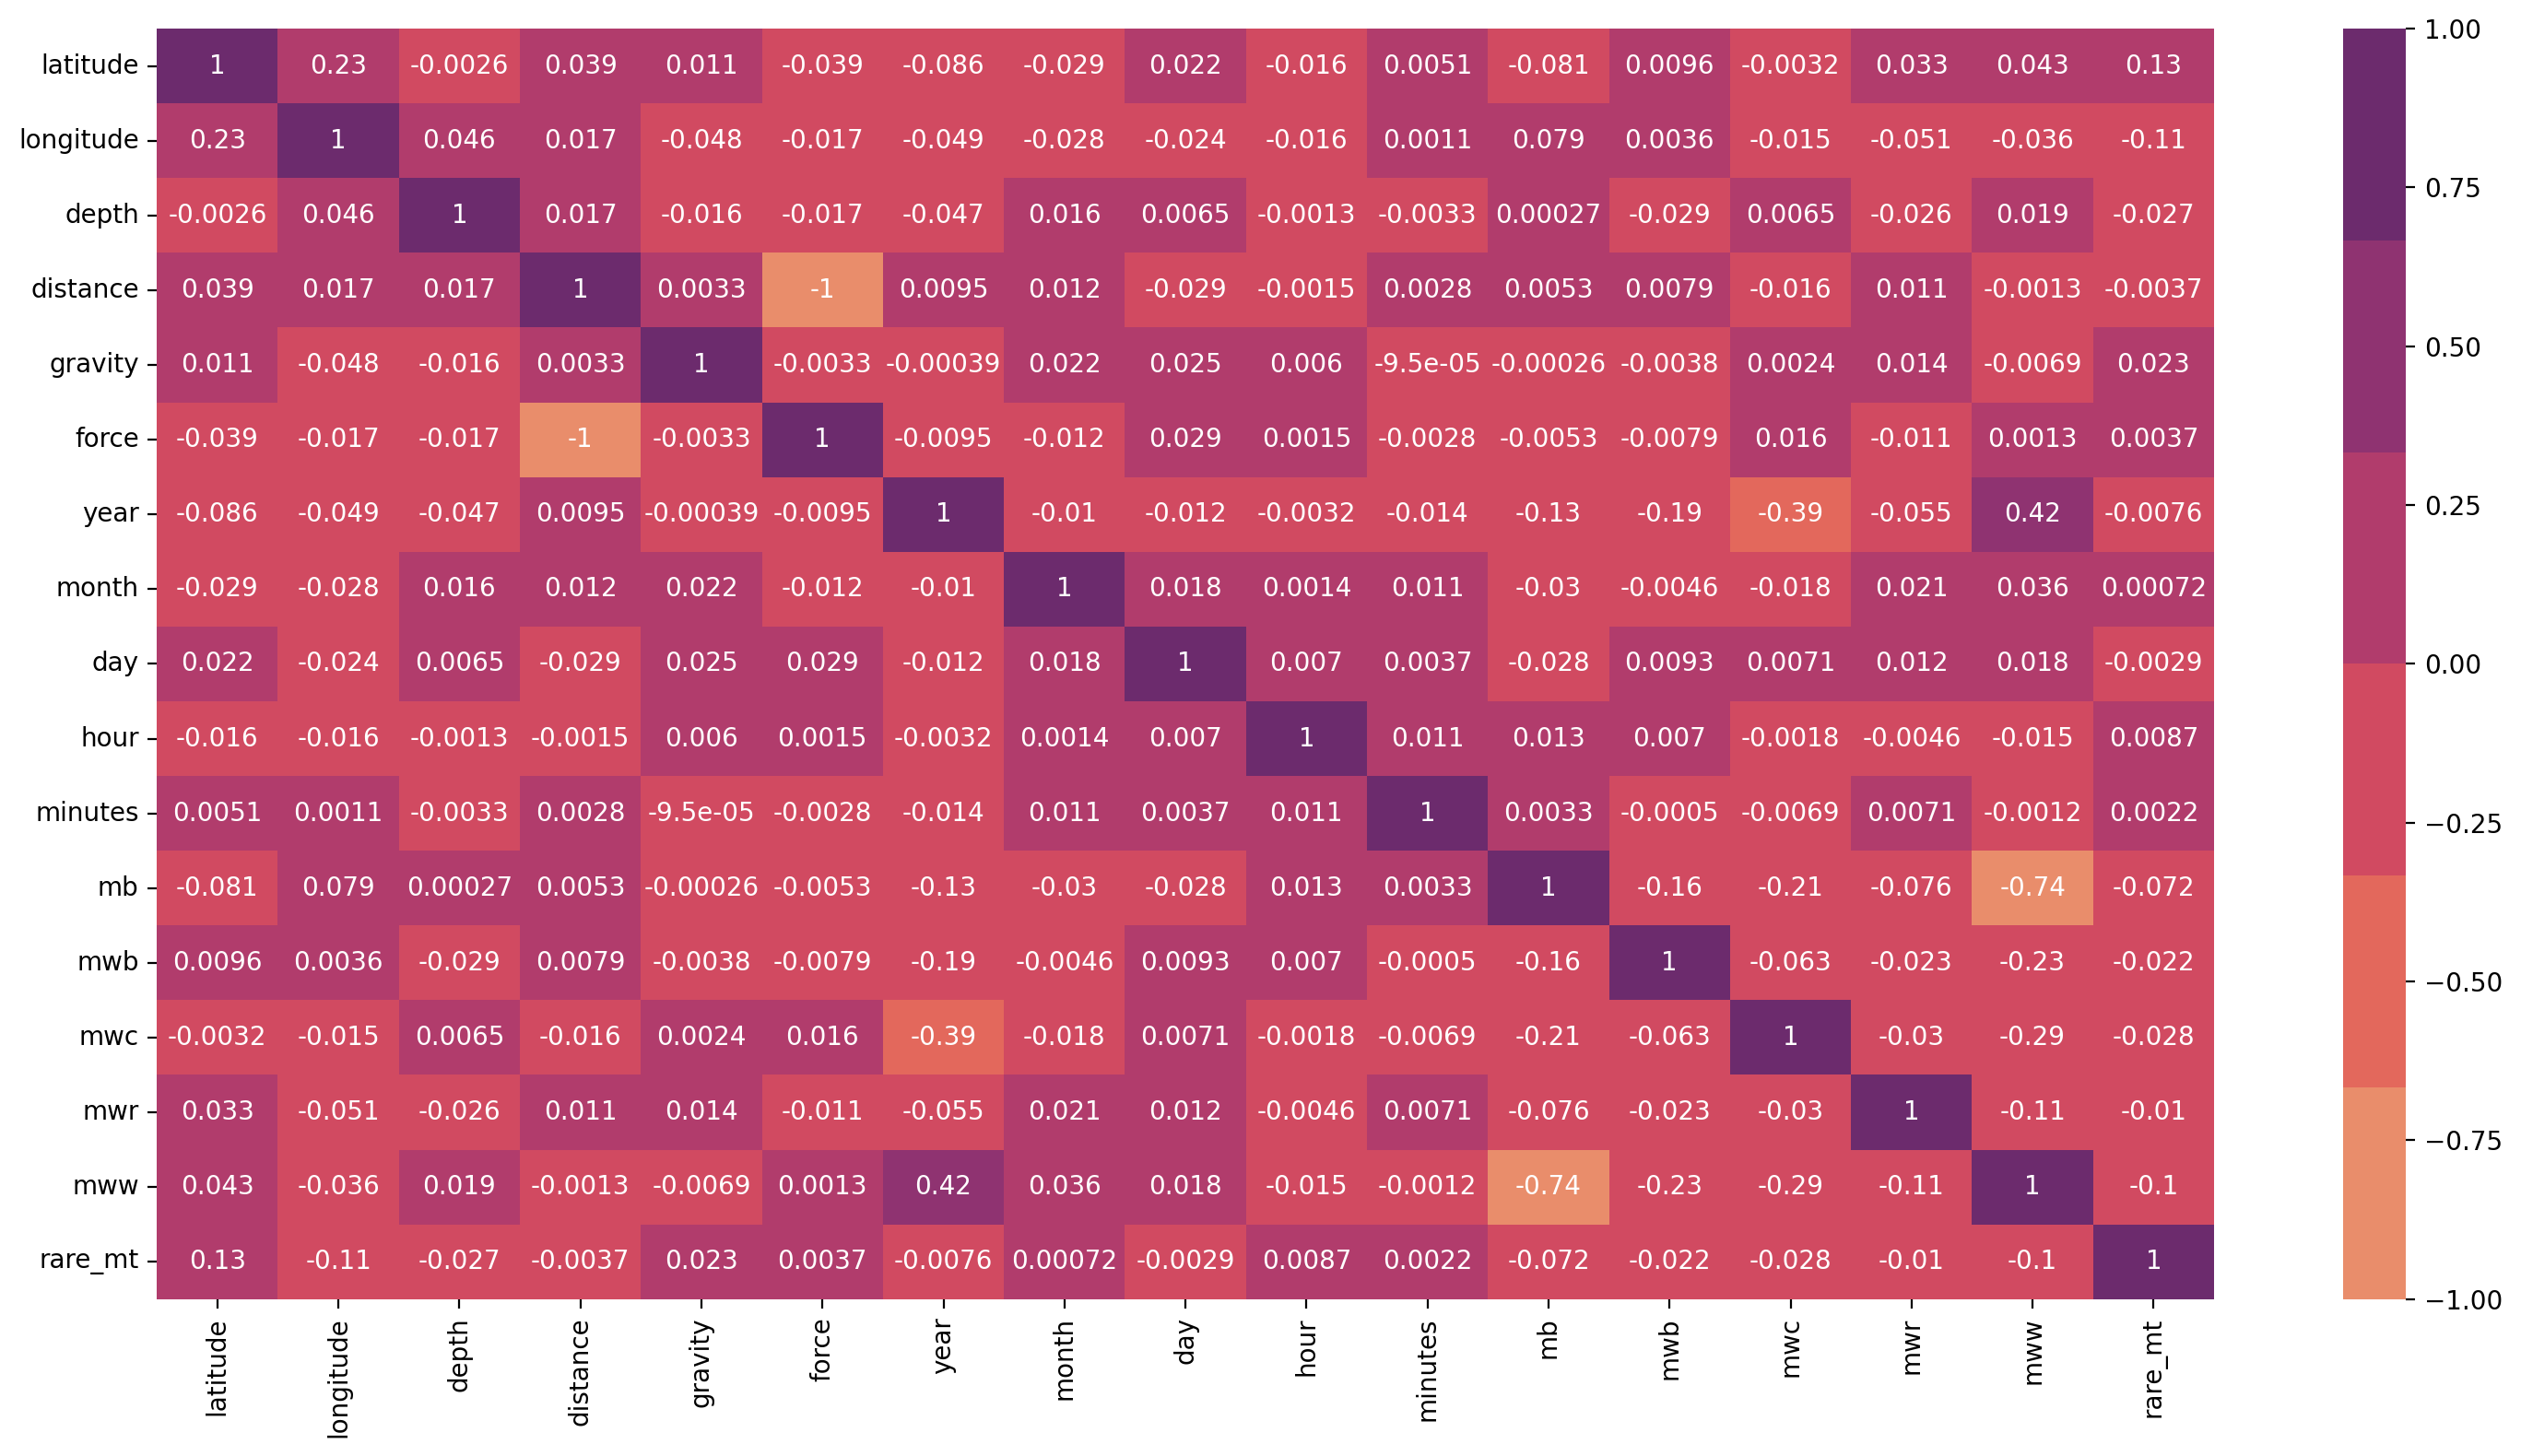

In [6]:
cor = X_train.select_dtypes(exclude=object).corr()
plt.figure(figsize=(15, 8), dpi = 200)
sns.heatmap(cor, annot=True, cmap=sns.color_palette('flare'))
plt.tight_layout()
plt.savefig('./images/corelation_matrix.png')
plt.show()


### 2. SelectFromModel and Lasso

#### First, specify the Lasso Regression model, and select a suitable alpha (equivalent of penalty).
#### The bigger the alpha the less features that will be selected.
    - Then use the selectFromModel object from sklearn, which will select the features which coefficients are non-zero


In [7]:
# remember to set the seed, the random state in this function it should be same for testing dataset
feature_sel_model_lasso = SelectFromModel(Lasso(alpha=0.005, random_state=0)) 
feature_sel_model_lasso.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [8]:
feature_sel_model_lasso.get_support()

array([ True,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True, False,  True, False,  True, False])

In [9]:
# let's print the number of total and selected features
# this is how we can make a list of the selected features
selected_feat_lasso = X_train.columns[(feature_sel_model_lasso.get_support())]

# lasso_fitted = feature_sel_model_lasso.estimator_

print('Total features: {}'.format((X_train.shape[1])))
print('Selected features: {}'.format(len(selected_feat_lasso)))
# print('Features with coefficients shrink to zero: {}'.format(
#     np.sum(lasso_fitted.coef_ == 0)))

Total features: 17
Selected features: 10


In [10]:
Selected_feature_lasso = X_train[selected_feat_lasso]
Selected_feature_lasso.head()

,latitude,longitude,depth,year,month,day,minutes,mb,mwc,mww
0,-6.7306,155.0899,3.555348,2014,12,23,19,1,0,0
1,2.4210,90.4340,3.430756,2012,12,6,24,1,0,0
2,-20.3307,-173.8138,2.302585,2021,2,3,11,1,0,0
3,-59.4030,-17.9994,2.302585,2023,3,3,53,0,0,1
4,-54.3240,159.1913,2.302585,2017,6,1,4,1,0,0


In [11]:
Not_selected_feature_lasso = X_train.columns[~(feature_sel_model_lasso.get_support())]
Not_selected_feature_lasso

Index(['distance', 'gravity', 'force', 'hour', 'mwb', 'mwr', 'rare_mt'], dtype='object')

### 3. Feature Selection Using Information Gain For Regression

In [12]:
from sklearn.feature_selection import mutual_info_regression

# determine the mutual information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info

/Users/ghanshyamsingh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1307: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.02878211, 0.03007151, 0.09190613, 0.02444093, 0.00592614,
       0.02406802, 0.00013662, 0.00509194, 0.00064129, 0.        ,
       0.        , 0.13595803, 0.01076496, 0.01012891, 0.01253783,
       0.1321412 , 0.00851492])

In [13]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

mb           0.135958
mww          0.132141
depth        0.091906
longitude    0.030072
latitude     0.028782
distance     0.024441
force        0.024068
mwr          0.012538
mwb          0.010765
mwc          0.010129
rare_mt      0.008515
gravity      0.005926
month        0.005092
day          0.000641
year         0.000137
minutes      0.000000
hour         0.000000
dtype: float64

/var/folders/vf/28sqncwx6v18cj6z8zjy48r80000gn/T/ipykernel_38145/1647441026.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = mutual_info.index, y = mutual_info.values, palette=sns.color_palette('flare', n_colors=len(mutual_info)))


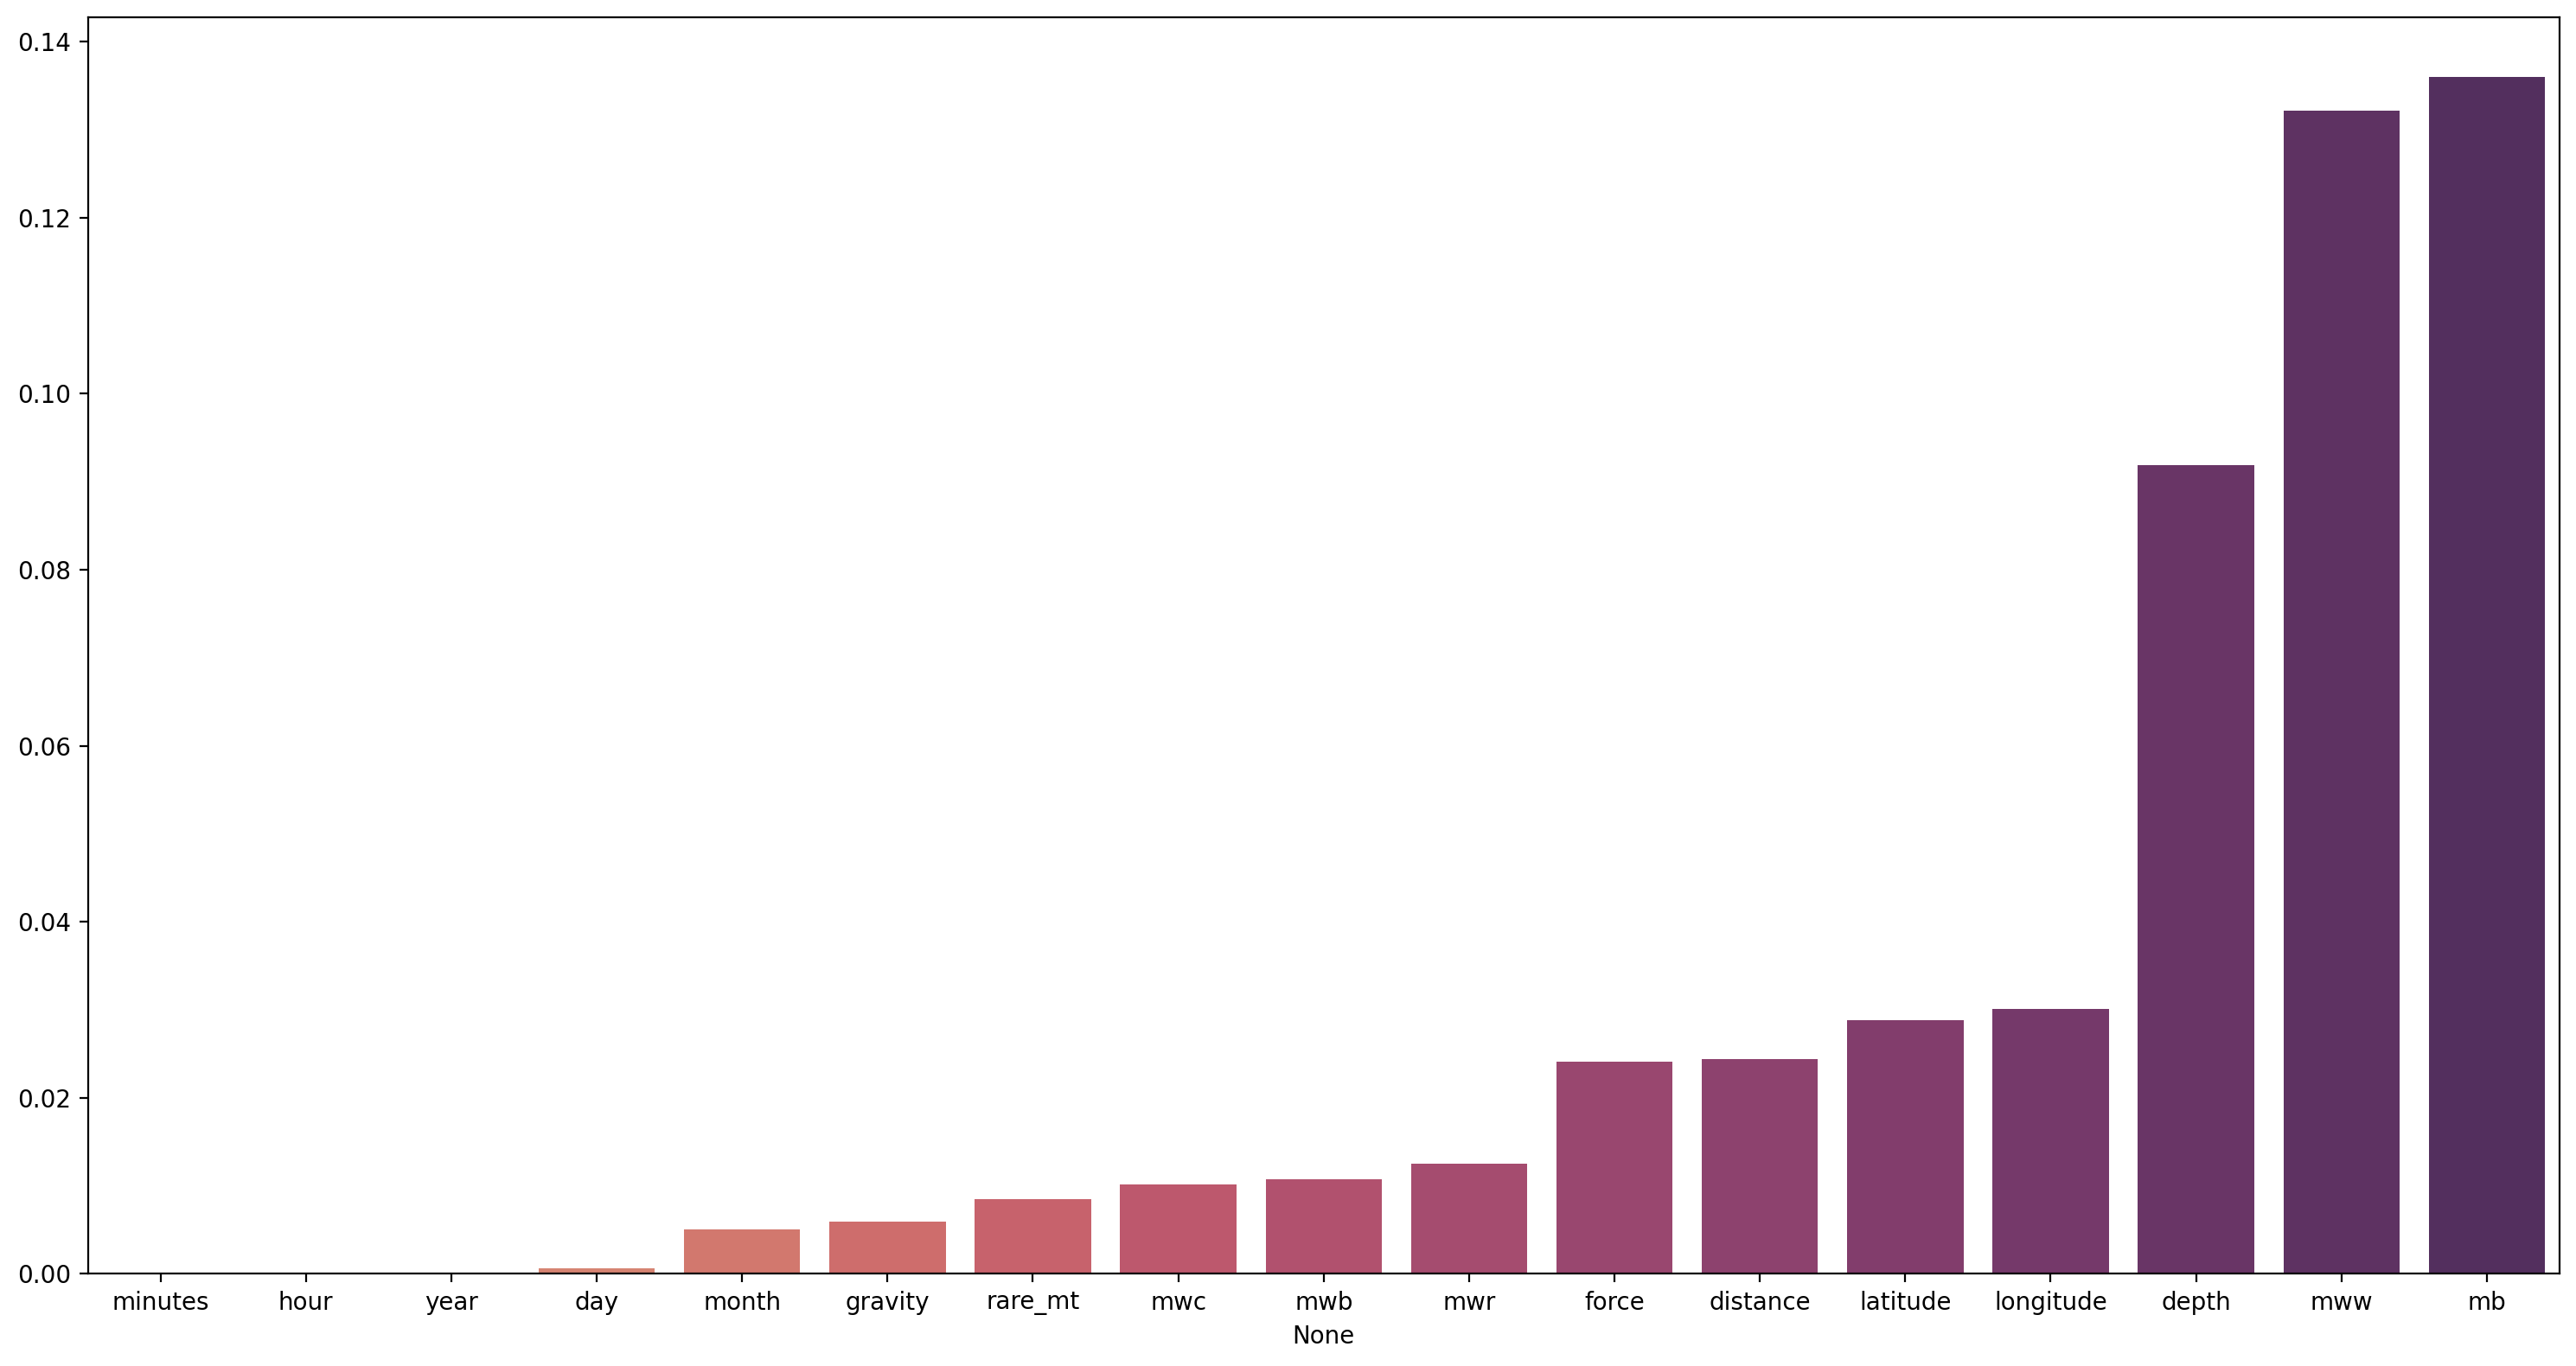

In [14]:
# mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))
mutual_info = mutual_info.sort_values(ascending=True)
plt.figure(figsize=(15, 8), dpi = 200)
sns.barplot(x = mutual_info.index, y = mutual_info.values, palette=sns.color_palette('flare', n_colors=len(mutual_info)))
plt.tight_layout()
plt.savefig('./images/feature_selection.png')
plt.show()

### 5. ANOVA OR F-Test

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [16]:
"""
f_regression()
Univariate linear regression tests.

Linear model for testing the individual effect of each of many regressors.
This is a scoring function to be used in a feature selection procedure, not
a free standing feature selection procedure.

This is done in 2 steps:

1. The correlation between each regressor and the target is computed,
   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *
   std(y)).
2. It is converted to an F score then to a p-value.
"""

'\nf_regression()\nUnivariate linear regression tests.\n\nLinear model for testing the individual effect of each of many regressors.\nThis is a scoring function to be used in a feature selection procedure, not\na free standing feature selection procedure.\n\nThis is done in 2 steps:\n\n1. The correlation between each regressor and the target is computed,\n   that is, ((X[:, i] - mean(X[:, i])) * (y - mean_y)) / (std(X[:, i]) *\n   std(y)).\n2. It is converted to an F score then to a p-value.\n'

In [17]:
feature_selector = SelectKBest(score_func=f_regression, k=10) # k is the number of features to be selected


# converting two-d to one-d for target variable
# y = np.array(y_train).ravel()
# y = np.array(y).reshape(-1,) 

# Apply feature selection
X_new_train = feature_selector.fit(X_train, y_train)


/Users/ghanshyamsingh/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1307: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# print(np.round('P-value', X_new_train.pvalues_,4))
# print(np.round('F-score', X_new_train.scores_,3))

In [19]:
features_score = pd.DataFrame(X_new_train.scores_)
features_pvalue = pd.DataFrame(np.round(X_new_train.pvalues_,4))
features = pd.DataFrame(X_train.columns)
feature_score = pd.concat([features,features_score,features_pvalue],axis=1)
# Assign the column name
feature_score.columns = ["Input_Features","F_Score","P_Value"]
print(feature_score.nlargest(10, columns="F_Score"))

   Input_Features      F_Score  P_Value
15            mww  3246.872322   0.0000
11             mb  2832.808002   0.0000
13            mwc    71.856381   0.0000
2           depth    70.707019   0.0000
14            mwr    41.283737   0.0000
4         gravity     1.876483   0.1708
16        rare_mt     1.830741   0.1761
3        distance     1.125785   0.2887
5           force     1.125785   0.2887
1       longitude     0.958198   0.3277


/var/folders/vf/28sqncwx6v18cj6z8zjy48r80000gn/T/ipykernel_38145/3632585493.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = feature_score['Input_Features'], y = feature_score['F_Score'], palette=sns.color_palette('flare', n_colors=len(feature_score)))


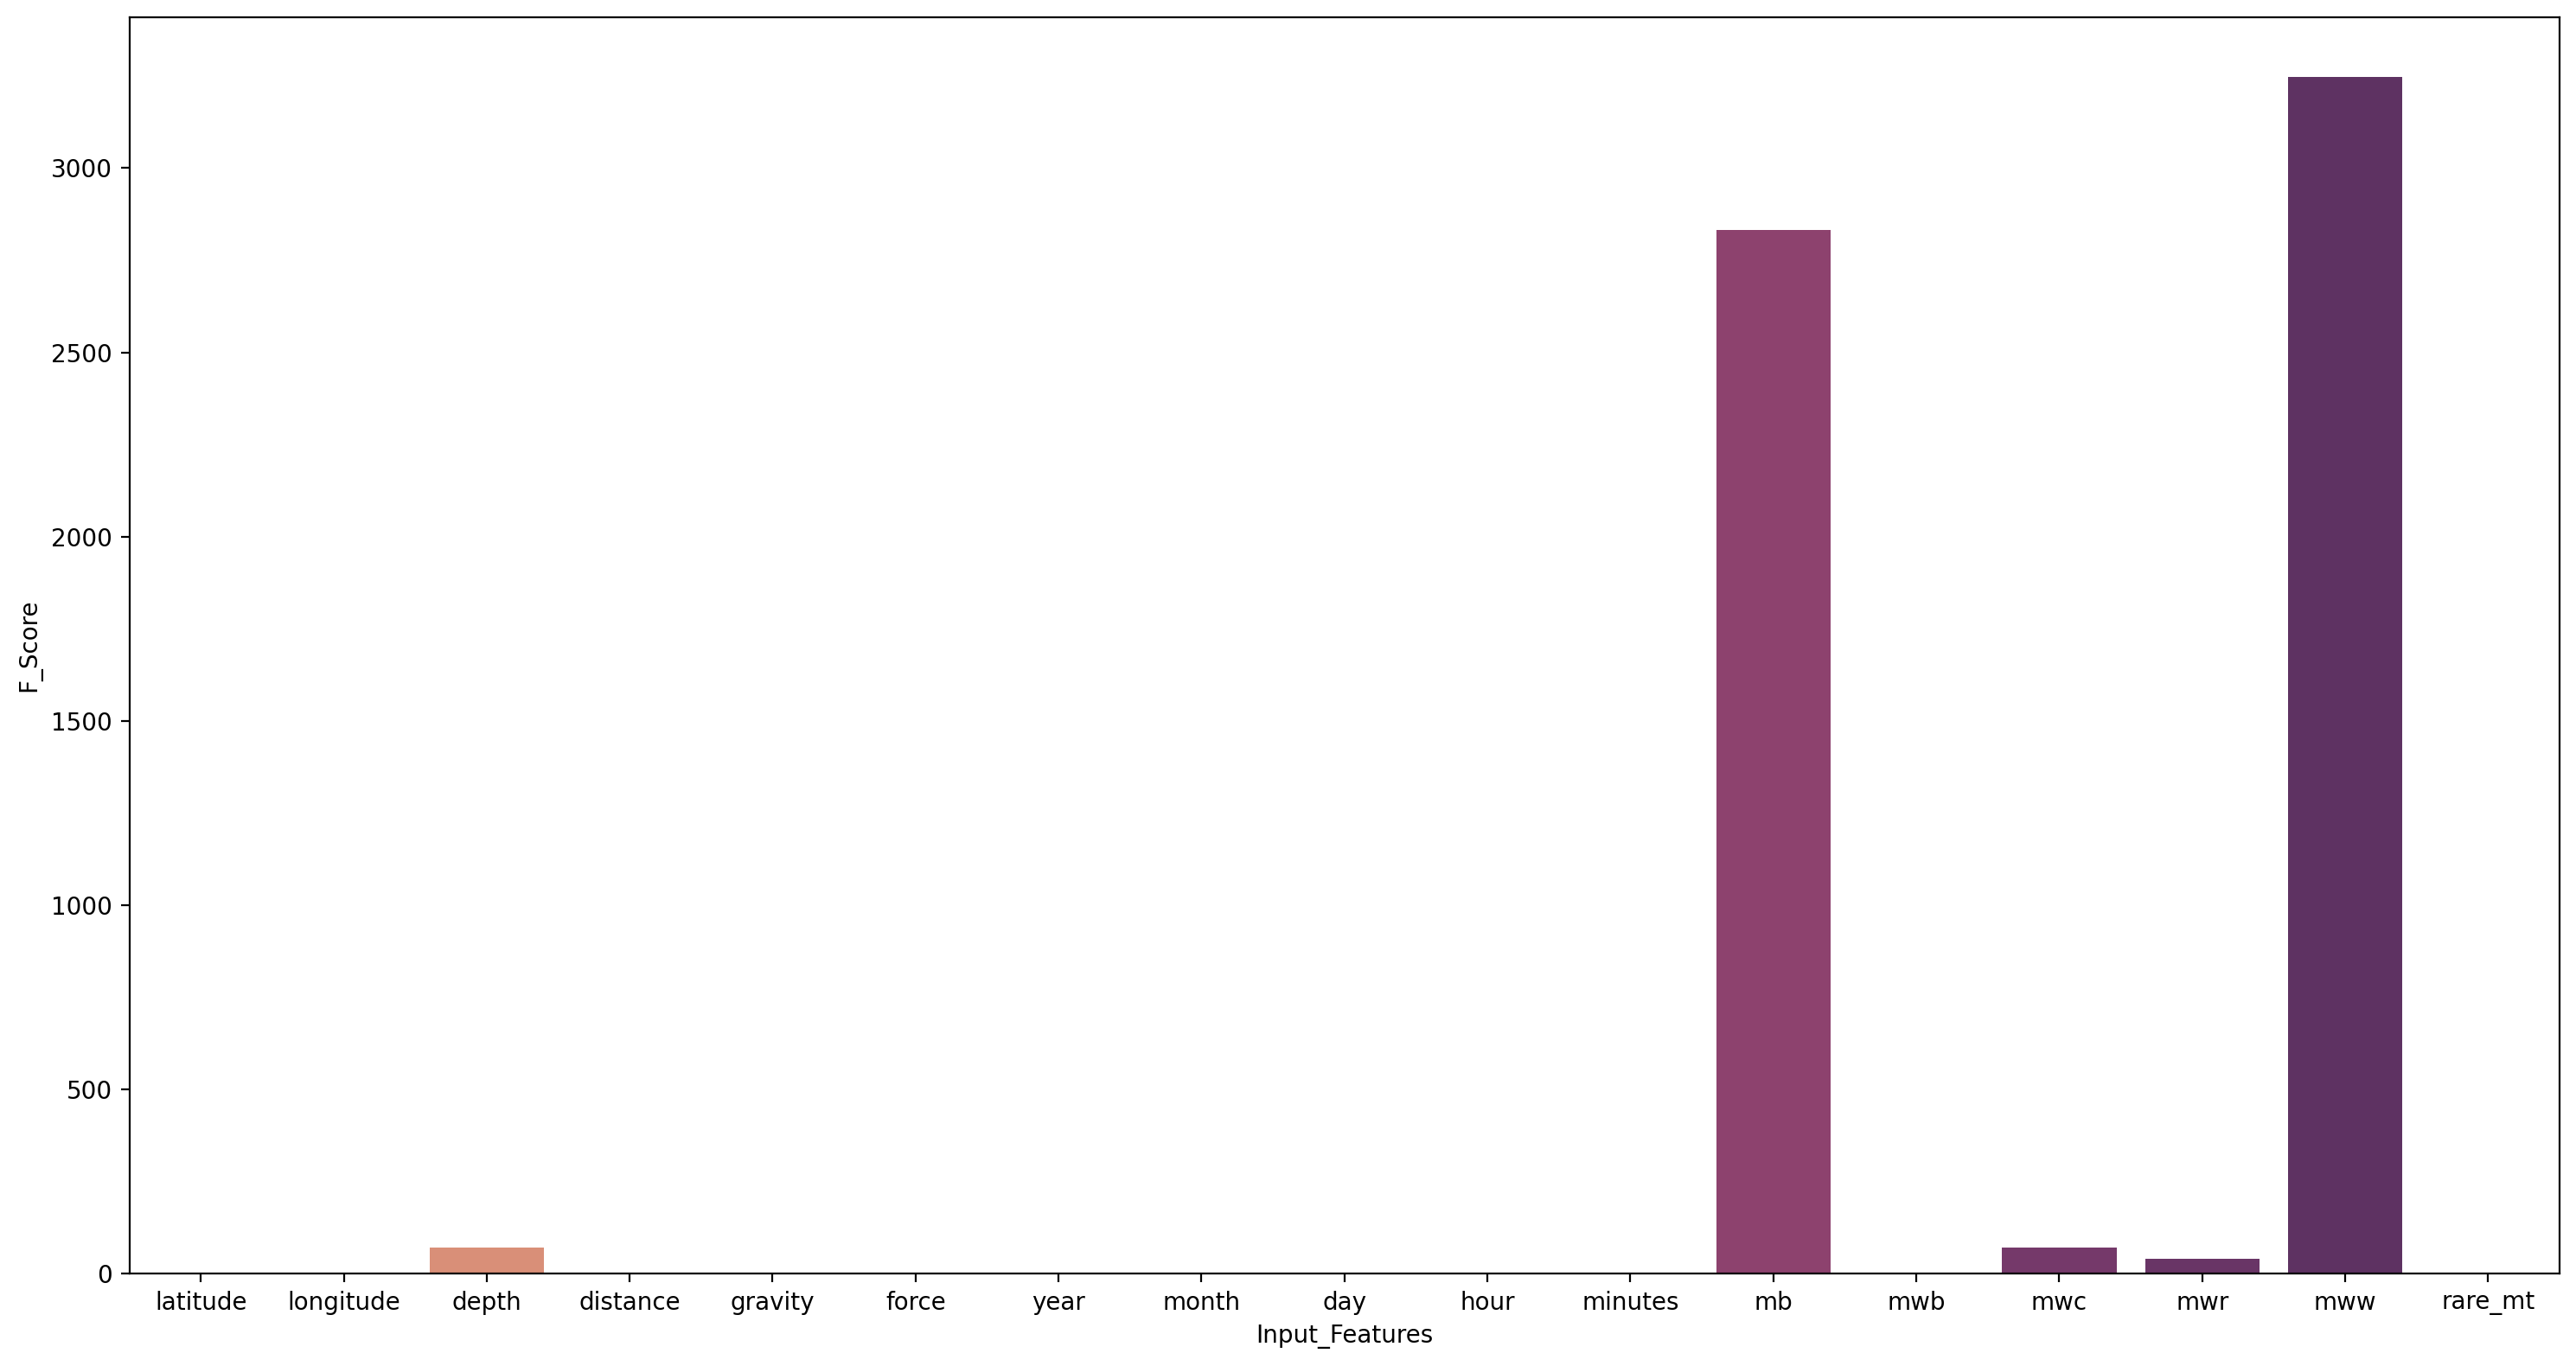

In [20]:

plt.figure(figsize=(15, 8), dpi = 200)
sns.barplot(x = feature_score['Input_Features'], y = feature_score['F_Score'], palette=sns.color_palette('flare', n_colors=len(feature_score)))
plt.tight_layout()
plt.savefig('./images/feature_selection.png')
plt.show()

In [21]:
feature_score_df = feature_score.nlargest(10, columns="F_Score")

/var/folders/vf/28sqncwx6v18cj6z8zjy48r80000gn/T/ipykernel_38145/143520821.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feature_score_df, x='Input_Features', y='F_Score', palette=sns.color_palette('flare', n_colors=len(feature_score_df)))


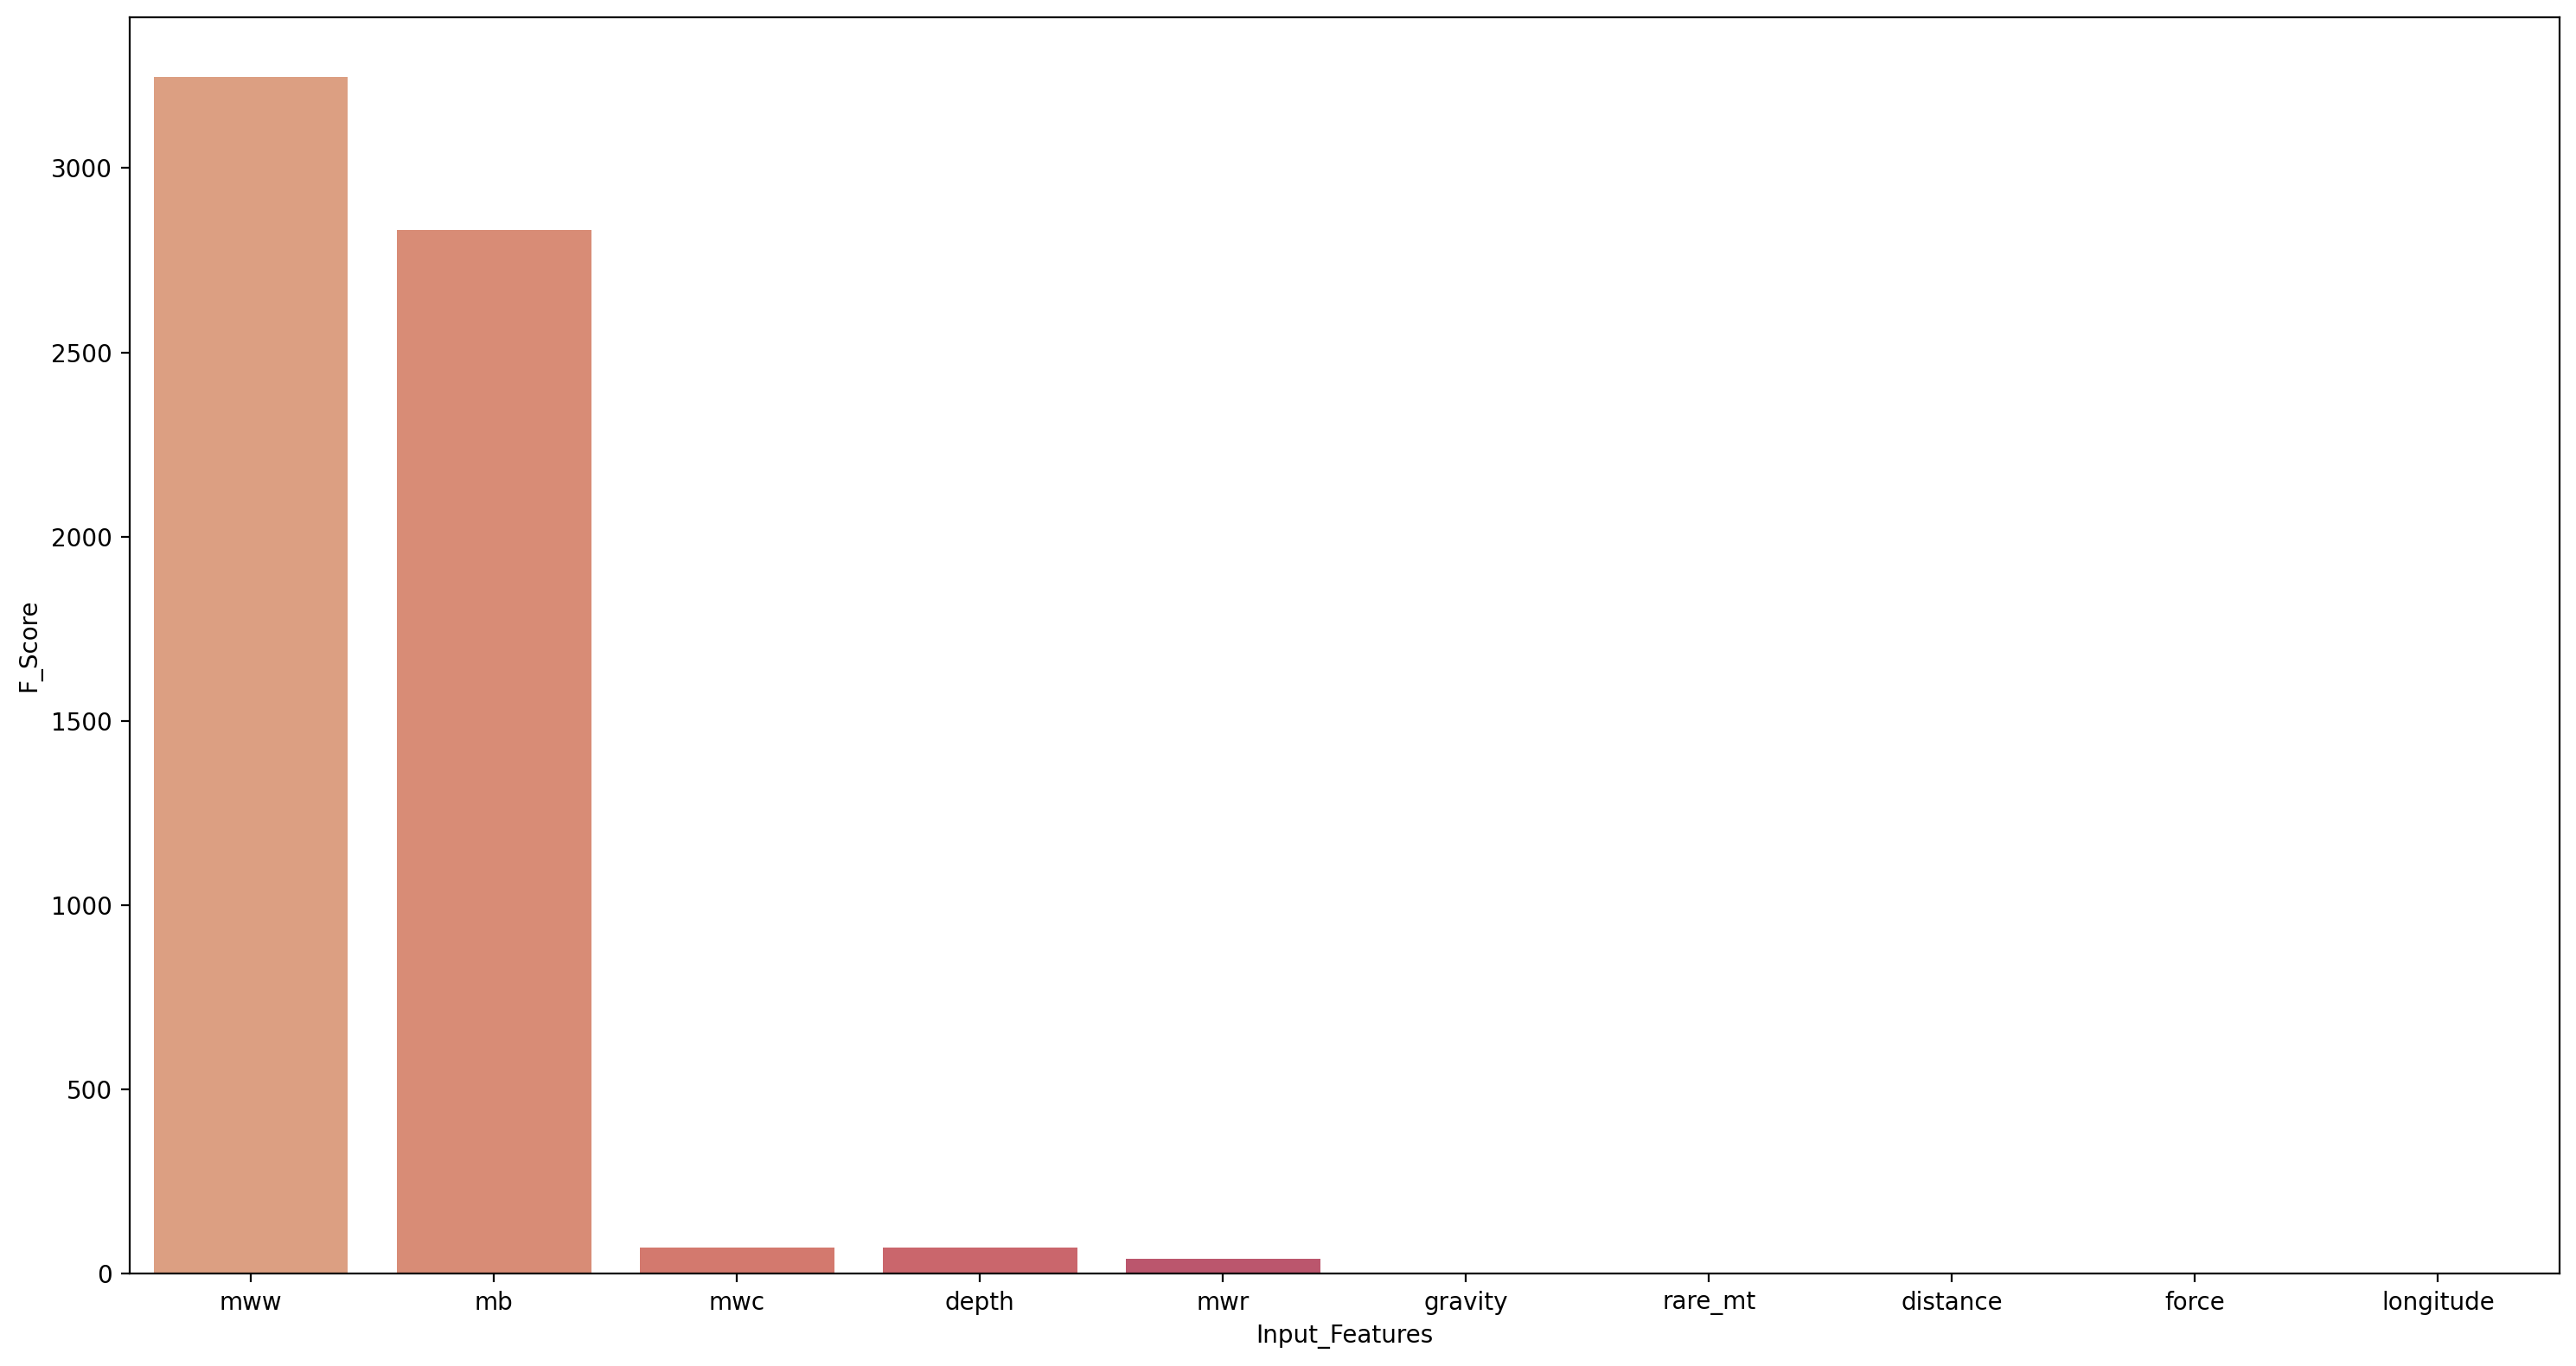

In [22]:
# fig = plt.figure(figsize=(10,4), dpi = 200)
# sns.barplot(feature_score_df, x='Input_Features', y='F_Score');
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(15, 8), dpi = 200)
sns.barplot(feature_score_df, x='Input_Features', y='F_Score', palette=sns.color_palette('flare', n_colors=len(feature_score_df)))
plt.tight_layout()
plt.show()

### On behalf of 4 different type of feature selection process. Following feature are selected for ML Model 
    - magnitude_type
    - depth, 
    - latitude,
    - longitude, 
    - force, 
    - distance, 
    - depth_min, 
    - gravity, 